In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
from pathlib import Path
from tqdm import trange
from flygym.mujoco import Parameters
from flygym.mujoco.examples.turning_controller import HybridTurningNMF
from flygym.mujoco.arena import OdorArena

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array(
    [[24, 0, 1.5], [8, -4, 1.5], [16, 4, 1.5], [12, -8, 1.5], [20, 3, 1.5]]
)

# Peak intensities: array of shape (num_odor_sources, odor_dimesions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case yeast). If it's (0, x) then it's in the 2nd dimension (in this case
# sucrose)
peak_intensity = np.array([[1, 0], [2, 0], [3, 0], [4, 0], [5, 0]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
marker_colors = [[255, 127, 14], [31, 119, 180], [255, 192, 203], [255, 0, 0], [0, 255, 0]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimesions = len(peak_intensity[0])

odor_valence = [10, 15, 20, 17, 6]

logging.basicConfig(level=logging.INFO)

In [2]:
# Set up the arena
arena = OdorArena(
    odor_source=odor_source,
    size=(50, 50),
    peak_intensity=peak_intensity,
    odor_valence=odor_valence,
    diffuse_func=lambda x: x**-2,
    marker_size=0.3,
    marker_colors=marker_colors
)

(-0.5, 799.5, 607.5, -0.5)

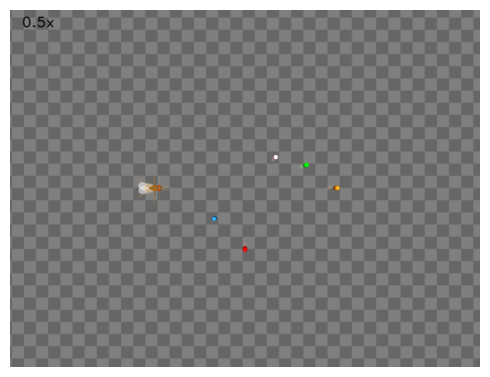

In [3]:
# Add the NeuroMechFLy

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
    simulation_time=30)
    #odor_score_reach_addition=2,
    #odor_score_time_loss=1
for i in range(1):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")

In [4]:
decision_interval = 0.01
run_time = sim.simulation_time
num_decision_steps = int(run_time / decision_interval)
logging.info("Number of decision steps: ", num_decision_steps)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)
logging.info("Physics steps per decision step: ", physics_steps_per_decision_step)

obs_hist = []
odor_history = []
obs, _ = sim.reset()

# let's choose the source towards which the fly will walk
source = sim.choose_odor_exploration()
prev_reward = None
logging.info("Going to the source ", source + 1)

# let's start the exploration
for i in trange(num_decision_steps):
    # compute the control signal to go towards the chosen source
    control_signal = arena.generate_specific_turning_control(
                source, sim
            )
    for _ in range(physics_steps_per_decision_step):
        obs, reward, terminated, truncated, _ = sim.step(control_signal, False)
        rendered_img = sim.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)

        if reward != None:
            # let's check if the fly has actually reached a new source
            if prev_reward != reward:
                # if it has, the sim.odor_scores is updated and a new source to be reached is computed
                sim.update_odor_scores(source)
                source = sim.choose_odor_exploration()
                logging.info("new source", source+1)
                logging.info(sim.odor_scores)
                prev_reward = reward
        if terminated:
            logging.info("Out of time")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break
        if truncated:
            logging.info("No food source was reached, simulation is truncated")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break

    

  0%|          | 1/3000 [00:00<10:57,  4.56it/s]

100%|██████████| 3000/3000 [14:33<00:00,  3.43it/s]


In [5]:
# let's check the confidence level for the fly's memory related to the different sources
print(sim.odor_scores)
# let's check the fly's memory 
print(sim.fly_valence_dictionary)

[15. 15. 15. 15. 15.]
{3: 20, 4: 17, 5: 6, 1: 10, 2: 15}


In [6]:
# choose a name to save both the video and the trajectory
name = "counting_based_simulation_9"
path = Path(f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}")
os.mkdir(path)

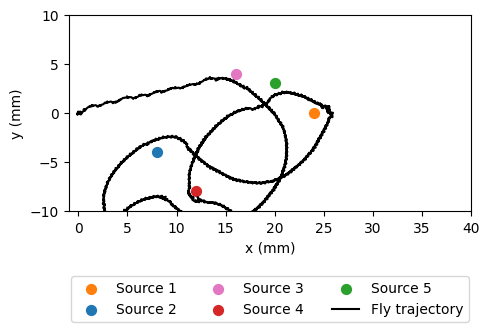

In [7]:
# Plot the trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Source 1",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Source 2",
)
ax.scatter(
    [odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:pink", s=50, label="Source 3",
)
ax.scatter(
    [odor_source[3, 0]], [odor_source[3, 1]], marker="o", color="tab:red", s=50, label="Source 4",
)
ax.scatter(
    [odor_source[4, 0]], [odor_source[4, 1]], marker="o", color="tab:green", s=50, label="Source 5",
)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-10, 10)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory.png"
)

In [8]:
# save the video
sim.save_video(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_video.mp4"
)